Script to compare some results from the full year and representative optimization using a MILP formulation.

In [1]:
from __future__ import division

import logging
import time

import pandas as pd
from pkg_resources import resource_filename
from pyomo.core.base import ConcreteModel, Objective, Constraint, minimize
from pyomo.opt import SolverFactory

import modesto.utils as ut
from misc.SDH_Conference_TestCases import CaseFuture
from modesto.main import Modesto

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

DATAPATH = resource_filename('modesto', 'Data')

from runOpt import get_json

from RepresentativeWeeks import representative, solve_repr, get_network_loss

In [2]:
VWat = 75000
solArea = 150000
VSTC = 100000

In [4]:
sellist = get_json('C:/Users/u0094934/Research/TimeSliceSelection/Scripts/solutions7.txt')
selection = sellist[8]

# selection = OrderedDict([(10, 2.0), (48, 12.0), (74, 2.0), (100, 10.0),
# (180, 5.0), (188, 7.0), (224, 5.0), (326, 9.0)])
time_step = 3600
duration_repr = 7
model, optimizers = representative(duration_repr=duration_repr,
                                   selection=selection, VWat=VWat, solArea=solArea, VSTC=VSTC, time_step=time_step)

begin = time.clock()
solve_repr(model, probe=False, solver='cplex')
print 'Solving time {}'.format(time.clock()-begin)

Writing time: 9.17601326822

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\u0094934\Research\modesto\misc\RepresentativePeriodsMILP\tmpexae2i.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.1
CPLEX> New value for level of mixed integer node display: 3
CPLEX> New value for parallel optimization mode: -1
CPLEX> New value for feasibility pump heuristic: 0
CPLEX> Problem 'C:\Users\u0094934\Research\modesto\misc\RepresentativePeriodsMILP\tmpfvclvs.pyomo.lp' read.
Read time = 0.27 sec. (19.89 ticks)
CPLEX> Problem name         : C:\Users\u0094934\Research\modesto\misc\RepresentativePeriodsMILP\tmpfvclvs.p

KeyboardInterrupt: 

In [ ]:
begin = time.clock()
full_model = CaseFuture.setup_opt(time_step=3600)
full_model.change_param(node='SolarArray', comp='solar', param='area', val=solArea)
full_model.change_param(node='SolarArray', comp='tank', param='volume', val=VSTC)
full_model.change_param(node='WaterscheiGarden', comp='tank', param='volume', val=VWat)

full_model.change_param(node='Production', comp='backup', param='ramp', val=0)
full_model.change_param(node='Production', comp='backup', param='ramp_cost', val=0)

full_model.compile('20140101')
full_model.set_objective('energy')
print 'Writing time: {}'.format(time.clock() - begin)


begin = time.clock()
full_model.solve(tee=True, mipgap=0.02, solver='gurobi', probe=True)
print 'Solving time: {}'.format(time.clock() - begin)

Writing time: 211.117085207


## Heat losses

In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


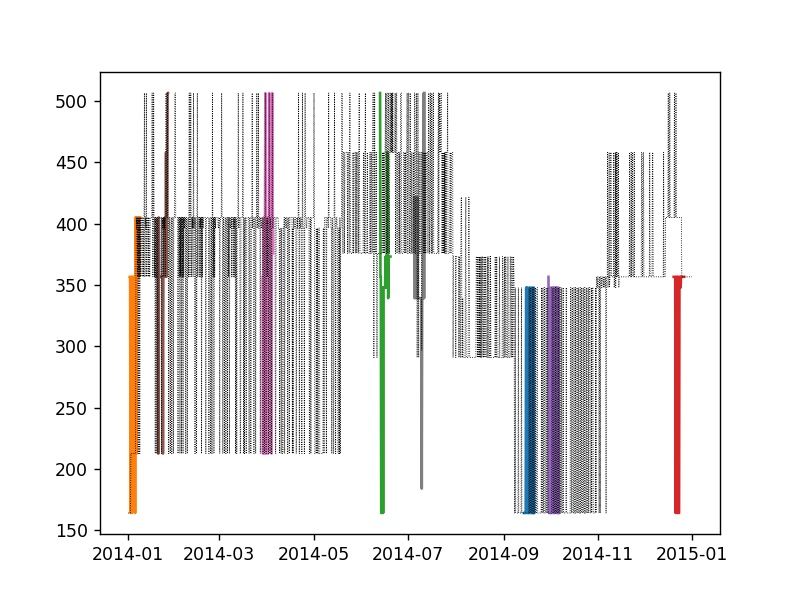

In [18]:
fig, axs = plt.subplots()

repr_loss = [sum(optmodel.get_result('heat_loss_tot', node=None, comp=pip, check_results=False)/ 1000 for pip in
        ['backBone', 'servWat',
         'servTer',
         'servPro',
         'servSol',
         'servBox']) for startday, optmodel in optimizers.iteritems()]

#print repr_loss

for i in repr_loss:
    axs.plot(i)
    
axs.plot(sum(full_model.get_result('heat_loss_tot', node=None, comp=pip)/1000 for pip in 
             ['backBone', 'servWat', 'servTer', 'servPro', 'servSol', 'servBox']), ':', linewidth=0.5, color='black')

## Calculate aggregated heat losses

In [19]:
repr_heat_loss = sum(sum(selection[startday]*optmodel.get_result('heat_loss_tot', node=None, comp=pip, check_results=False).sum()/ 1000 for pip in ['backBone', 'servWat',
         'servTer',
         'servPro',
         'servSol',
         'servBox']) for startday, optmodel in optimizers.iteritems())
print 'repr_heat_loss:', repr_heat_loss

full_heat_loss = sum(full_model.get_result('heat_loss_tot', node=None, comp=pip).sum()/1000 for pip in 
             ['backBone', 'servWat', 'servTer', 'servPro', 'servSol', 'servBox'])

print 'full_heat_loss:', full_heat_loss

print (repr_heat_loss - full_heat_loss)/full_heat_loss

repr_heat_loss: 477124.1722747948
full_heat_loss: 510113.69241881534
-0.06467091676679673


## Calculate other aggregated values

In [20]:
def plot_differences(node, comp, var):
    fig, axs = plt.subplots()

    repr_loss = [optmodel.get_result(var, node=node, comp=comp, check_results=False)/ 1000 for startday, optmodel in optimizers.iteritems()]

    #print repr_loss

    for i in repr_loss:
        axs.plot(i)

    axs.plot(full_model.get_result(var, node=node, comp=comp)/1000, ':', linewidth=0.5, color='black')
    
    return fig

In [21]:
def calc_aggr(node, comp, var):
    repr_res = sum(selection[startday]*optmodel.get_result(var, node=node, comp=comp, check_results=False).sum()/ 1000 for startday, optmodel in optimizers.iteritems())
    print 'Repres', var+':', repr_res

    full_res = full_model.get_result(var, node=node, comp=comp).sum()/1000

    print 'Full', var+':', full_res

### Backup production

<IPython.core.display.Javascript object>


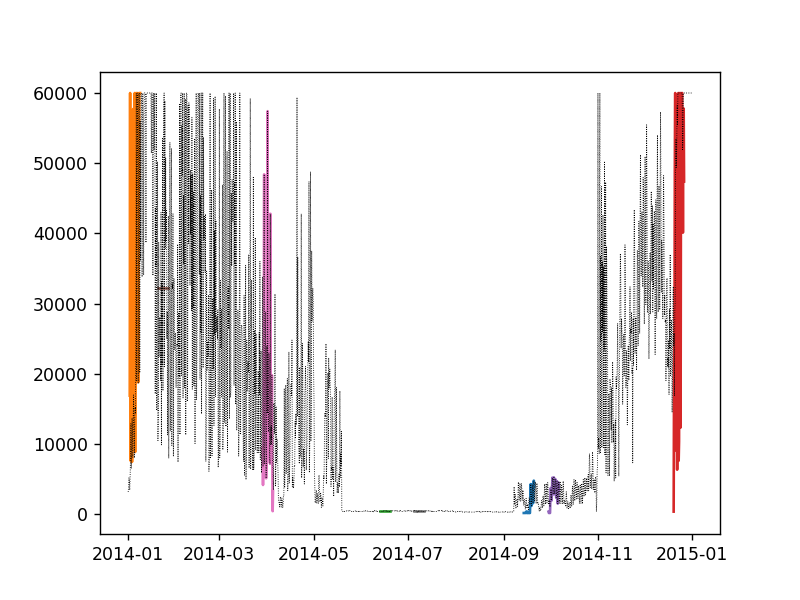

In [22]:
_=plot_differences('Production', 'backup', 'heat_flow')

In [21]:
calc_aggr('Production', 'backup', 'heat_flow')

Repres heat_flow: 421809.2794181759
Full heat_flow: 23098203.921626937


### Solar thermal collector field

<IPython.core.display.Javascript object>


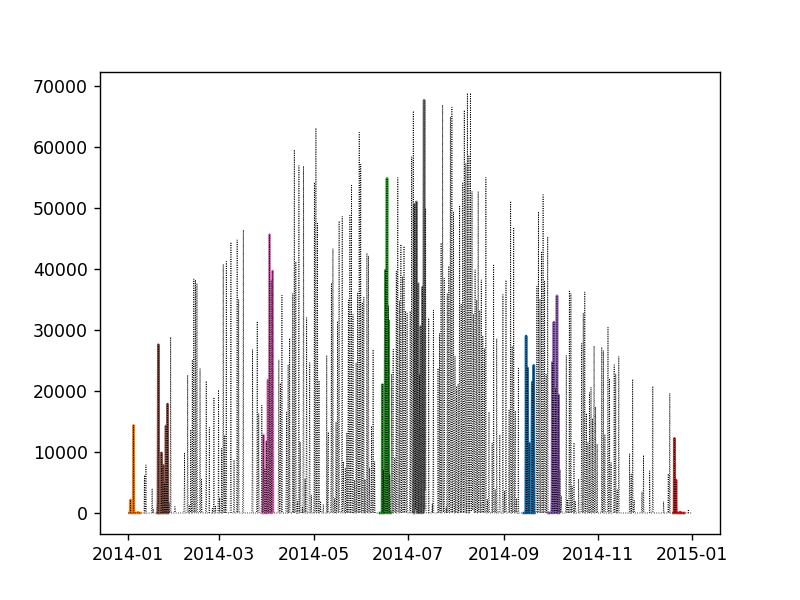

In [14]:
_=plot_differences('SolarArray', 'solar', 'heat_flow')

In [15]:
calc_aggr('SolarArray', 'solar', 'heat_flow')

Repres heat_flow: 9247873.431047263
Full heat_flow: 8417460.10052655


<IPython.core.display.Javascript object>


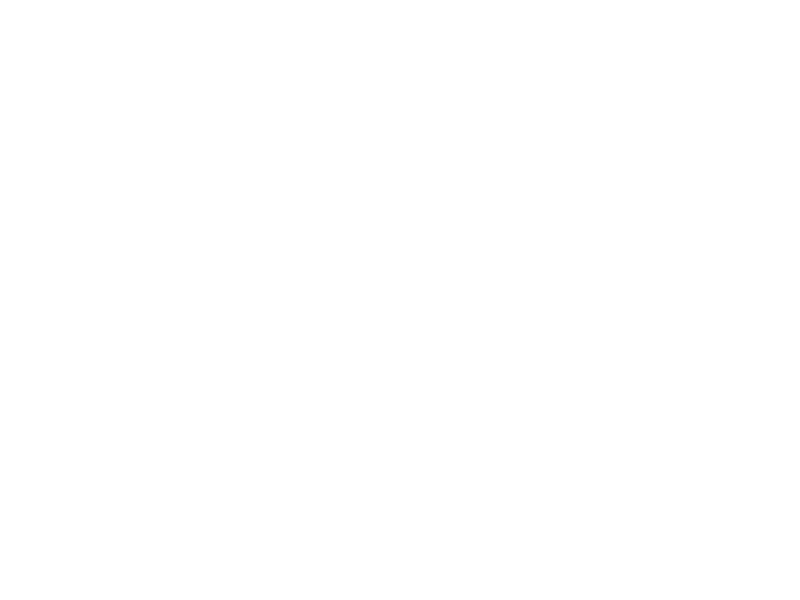

start_day: 1
2014-01-02 00:00:00
start_day: 19
2014-01-20 00:00:00
start_day: 87
2014-03-29 00:00:00
start_day: 163
2014-06-13 00:00:00
start_day: 185
2014-07-05 00:00:00
start_day: 256
2014-09-14 00:00:00
start_day: 272
2014-09-30 00:00:00
start_day: 353
2014-12-20 00:00:00


<IPython.core.display.Javascript object>


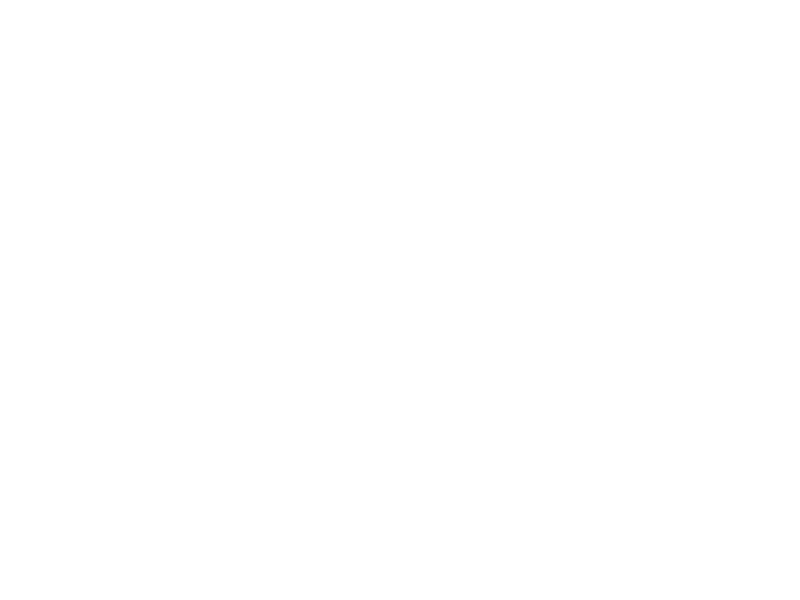

NameError: name 'plot_representative' is not defined

In [27]:
# ## Post-processing

# In[ ]:

import matplotlib.pyplot as plt
import numpy as np

t_amb = ut.read_time_data(DATAPATH, name='Weather/extT.csv',
                          expand=True)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(selection))]

coli = 0

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
for startday, reps in selection.iteritems():
    res = sum(optimizers[startday].get_result('heat_flow', node=node,
                                              comp='tank',
                                              check_results=False) for node in
              ['SolarArray', 'WaterscheiGarden', 'TermienWest'])
    ax1.plot(res, color=colors[coli],
             label='S {} R {}'.format(startday, reps))
    ax1.plot(optimizers[startday].get_result('heat_flow', node='SolarArray',
                                             comp='solar',
                                             check_results=False),
             color=colors[coli], linestyle=':')
    ax1.plot(sum(optimizers[startday].get_result('heat_flow', node=node,
                                                 comp='neighb',
                                                 check_results=False) for node in
                 ['TermienWest', 'WaterscheiGarden', 'TermienWest']),
             color=colors[coli], linestyle='-.')
    ax1.plot(optimizers[startday].get_result('heat_flow', node='Production',
                                             comp='backup',
                                             check_results=False),
             color=colors[coli], linestyle='--')

    print 'start_day:', str(startday)
    res = optimizers[startday].get_component(name='tank',
                                             node='SolarArray').get_heat_stor()
    start = pd.Timestamp('20140101') + pd.Timedelta(days=startday)
    print start
    index = pd.DatetimeIndex(start=start, freq=pd.Timedelta(seconds=time_step), periods=len(res))
    ax2.plot(index, res, color=colors[coli],
             label='S {} R {}'.format(startday, reps))

    ax3.plot(optimizers[startday].get_result('heat_loss_ct', node='SolarArray',
                                             comp='tank',
                                             check_results=False))
    ax3b = ax3.twinx()
    ax3b.plot(-t_amb['Te'], linestyle=':')
    coli += 1

fig.tight_layout()

# In[ ]:
fig, ax = plt.subplots()
startdate = pd.Timestamp('20140101')
nextdate = startdate

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(selection))]

coli = 0

for startday, reps in selection.iteritems():
    res = optimizers[startday].get_component(name='tank',
                                             node='SolarArray').get_soc()
    index = pd.DatetimeIndex(start=nextdate, freq=pd.Timedelta(seconds=time_step), periods=len(res))
    ax.plot(index, res, color=colors[coli], label=str(startday))
    nextdate = nextdate + pd.Timedelta(days=duration_repr * reps)
    coli += 1

ax.legend()
plt.gcf().autofmt_xdate()

fig1 = plot_representative(
    optimizers, selection, duration_repr=duration_repr, time_step=time_step)